In [1]:
#Importing necessary libraries

import requests
import pandas as pd
import numpy as np
import joblib
from datetime import datetime, timedelta
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
class SolarPowerPredictorPaperModel:
    def __init__(self, lat, lon, panel_area, panel_efficiency, lags=24, timezone='UTC'):
        # Initialize model parameters including location, panel specs, lag configuration, and timezone.
        self.lat = lat
        self.lon = lon
        self.panel_area = panel_area
        self.panel_eff = panel_efficiency
        self.lags = lags
        self.timezone = timezone
        self.model = None
        self.features = None

    def fetch_weather(self, start, end, source='archive'):
        # Fetch weather data (historical or forecast) from the Open-Meteo API for the given date range.
        url = (
            'https://archive-api.open-meteo.com/v1/archive' if source == 'archive'
            else 'https://api.open-meteo.com/v1/forecast'
        )
        params = {
            'latitude': self.lat,
            'longitude': self.lon,
            'start_date': start.strftime('%Y-%m-%d'),
            'end_date': end.strftime('%Y-%m-%d'),
            'hourly': 'shortwave_radiation,temperature_2m,cloudcover,relativehumidity_2m',
            'timezone': self.timezone
        }
        response = requests.get(url, params=params)
        response.raise_for_status()
        return response.json()

    def preprocess(self, data):
        # Convert raw JSON weather data into a cleaned DataFrame with computed features for solar power forecasting.
        hourly = data.get('hourly', {})
        if not hourly or not hourly.get('time'):
            print("Warning: No hourly data found in API response.")
            return pd.DataFrame()

        try:
            df = pd.DataFrame({
                'ds': pd.to_datetime(hourly['time']),
                'irradiance': np.array(hourly['shortwave_radiation'], dtype=float),
                'temperature': np.array(hourly['temperature_2m'], dtype=float),
                'cloudcover': np.array(hourly['cloudcover'], dtype=float),
                'humidity': np.array(hourly['relativehumidity_2m'], dtype=float)
            })
        except (KeyError, ValueError) as e:
            print(f"Error creating DataFrame from API data: {e}")
            return pd.DataFrame()

        df.sort_values('ds', inplace=True)
        df.ffill(inplace=True)
        df['y'] = (df['irradiance'] * self.panel_area * self.panel_eff).clip(lower=0)
        df['hour'] = df['ds'].dt.hour
        df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
        df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)
        df['is_daylight'] = (df['irradiance'] > 10).astype(int)

        return df

    def create_lag_features(self, df):
        # Generate lag features for solar power and weather variables to capture temporal dependencies for forecasting.
        df_copy = df.copy()
        for lag in range(1, self.lags + 1):
            df_copy[f'y_lag_{lag}'] = df_copy['y'].shift(lag)

        for feature in ['irradiance', 'temperature', 'cloudcover', 'humidity']:
            for lag in range(1, self.lags + 1):
                df_copy[f'{feature}lag{lag}'] = df_copy[feature].shift(lag)

        df_copy.dropna(inplace=True)
        return df_copy

    def train_model(self, df):
        # Train a Gradient Boosting Regressor model using lag features from historical data and save the trained model.
        print("Creating features and training model")
        df_lagged = self.create_lag_features(df)
        X = df_lagged.drop(columns=['ds', 'y'])
        y = df_lagged['y']

        self.features = X.columns
        self.model = GradientBoostingRegressor(
            n_estimators=300,
            learning_rate=0.1,
            max_depth=5,
            random_state=42,
            loss='huber'
        )
        self.model.fit(X, y)
        joblib.dump(self.model, 'solar_gbr_model.pkl')
        print("Model saved as 'solar_gbr_model.pkl'")
        print("Gradient Boosting model training complete.")

    def predict(self, df_with_context):
        # Predict future solar power output using forecast data enriched with lag features, then save and display the results.
        print("\nCreating features for forecast data...")
        df_lagged = self.create_lag_features(df_with_context)

        if df_lagged.empty:
            print("Not enough data to create features for prediction.")
            return pd.DataFrame()

        X = df_lagged[self.features]
        y_pred = self.model.predict(X)
        y_pred_clipped = np.clip(y_pred, 0, None)

        df_result = df_lagged[['ds']].copy()
        df_result['predicted_power'] = y_pred_clipped
        df_result.to_csv('hourly_predictions.csv', index=False)
        print("Predicted hourly power output saved to 'hourly_predictions.csv'")
        print("\nPrediction Results (in Local Time):")
        print(df_result.to_string(index=False))
        return df_result

    def evaluate(self, df):
        # Evaluate the model on historical data by computing error metrics and visualizing the top feature importances.
        df_lagged = self.create_lag_features(df.copy())
        if df_lagged.empty:
            print("Not enough data to evaluate the model.")
            return

        X = df_lagged[self.features]
        y_true = df_lagged['y']
        y_pred = self.model.predict(X)
        y_pred_clipped = np.clip(y_pred, 0, None)

        mae = mean_absolute_error(y_true, y_pred_clipped)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred_clipped))
        print(f"\nModel Evaluation on Historical Data:\nMAE: {mae:.2f}, RMSE: {rmse:.2f}")

        # importances = self.model.feature_importances_
        # feat_imp = pd.Series(importances, index=self.features).nlargest(20)

        # plt.figure(figsize=(12, 8))
        # sns.barplot(x=feat_imp.values, y=feat_imp.index, palette="viridis")
        # plt.title('Top 20 Feature Importances - Gradient Boosting')
        # plt.xlabel('Importance')
        # plt.ylabel('Features')
        # plt.tight_layout()
        # plt.show()

    def run(self):
        # Execute the full pipeline: fetch historical and forecast weather data, train & evaluate the model, then predict and plot solar power output.
        today = datetime.utcnow()
        print(f"Running pipeline for timezone: {self.timezone}")

        print(f"Fetching historical weather data.")
        hist_json = self.fetch_weather(today - timedelta(days=365), today - timedelta(days=1))
        df_hist = self.preprocess(hist_json)

        if df_hist.empty:
            print("No historical data fetched. Aborting.")
            return

        self.train_model(df_hist)
        self.evaluate(df_hist)

        print("\nFetching forecast weather data|.")
        forecast_json = self.fetch_weather(today, today + timedelta(days=2), source='forecast')
        df_forecast = self.preprocess(forecast_json)

        if df_forecast.empty:
            print("No forecast data fetched. Aborting.")
            return

        df_for_prediction = pd.concat([df_hist.tail(self.lags), df_forecast], ignore_index=True)
        df_prediction = self.predict(df_for_prediction)

        if df_prediction.empty:
            return

        plt.figure(figsize=(15, 6))
        plt.plot(df_prediction['ds'], df_prediction['predicted_power'], label='Predicted Power', color='purple', marker='.')
        plt.title('Solar Power Forecast - Gradient Boosting')
        plt.xlabel(f'Datetime ({self.timezone})')
        plt.ylabel('Power Output (W)')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()


Running pipeline for timezone: Asia/Kolkata
Fetching historical weather data.
Creating features and training model


<ipython-input-6-4bdbc4dd34c7>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{feature}lag{lag}'] = df_copy[feature].shift(lag)
<ipython-input-6-4bdbc4dd34c7>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{feature}lag{lag}'] = df_copy[feature].shift(lag)
<ipython-input-6-4bdbc4dd34c7>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. 

Model saved as 'solar_gbr_model.pkl'
Gradient Boosting model training complete.

Model Evaluation on Historical Data:
MAE: 0.04, RMSE: 0.12

Fetching forecast weather data|.


<ipython-input-6-4bdbc4dd34c7>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{feature}lag{lag}'] = df_copy[feature].shift(lag)
<ipython-input-6-4bdbc4dd34c7>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{feature}lag{lag}'] = df_copy[feature].shift(lag)
<ipython-input-6-4bdbc4dd34c7>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. 


Creating features for forecast data...
Predicted hourly power output saved to 'hourly_predictions.csv'

Prediction Results (in Local Time):
                 ds  predicted_power
2025-06-10 00:00:00         0.000301
2025-06-10 01:00:00         0.000301
2025-06-10 02:00:00         0.000301
2025-06-10 03:00:00         0.000491
2025-06-10 04:00:00         0.000491
2025-06-10 05:00:00        11.833124
2025-06-10 06:00:00        64.322988
2025-06-10 07:00:00       130.401084
2025-06-10 08:00:00       192.131928
2025-06-10 09:00:00       220.171943
2025-06-10 10:00:00       243.226266
2025-06-10 11:00:00       272.119703
2025-06-10 12:00:00       275.500266
2025-06-10 13:00:00       251.623781
2025-06-10 14:00:00       201.497621
2025-06-10 15:00:00       154.871287
2025-06-10 16:00:00       108.163078
2025-06-10 17:00:00        57.465471
2025-06-10 18:00:00         9.279884
2025-06-10 19:00:00         0.000000
2025-06-10 20:00:00         0.000766
2025-06-10 21:00:00         0.000766
2025-06-

<ipython-input-6-4bdbc4dd34c7>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{feature}lag{lag}'] = df_copy[feature].shift(lag)
<ipython-input-6-4bdbc4dd34c7>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{feature}lag{lag}'] = df_copy[feature].shift(lag)
<ipython-input-6-4bdbc4dd34c7>:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. 

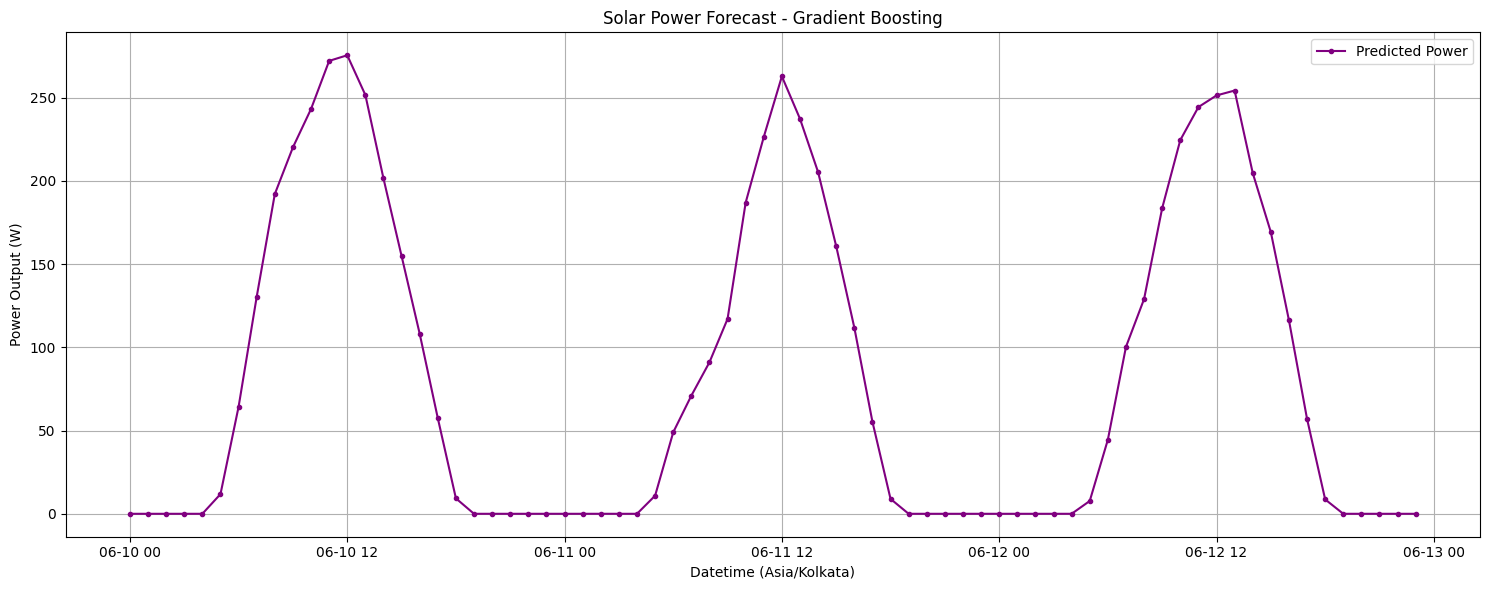

In [7]:
if __name__ == '__main__':
    LAT, LON = 26.0234, 89.9702
    PANEL_AREA, EFFICIENCY = 1.6, 0.20

    predictor = SolarPowerPredictorPaperModel(
        lat=LAT,
        lon=LON,
        panel_area=PANEL_AREA,
        panel_efficiency=EFFICIENCY,
        timezone='Asia/Kolkata'
    )
    predictor.run()
